In [121]:
# Load required libraries
library(haven)
library(dplyr)
library(tidyr)
library(ggplot2)

# install ggplot
install.packages("ggplot2")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [122]:
# load data

demo <- read_xpt("/content/xptfiles/demographics.xpt")
bp <- read_xpt("/content/xptfiles/bloodpressure.xpt")
hepb <- read_xpt("/content/xptfiles/hepb.xpt")
kidney <- read_xpt("/content/xptfiles/kidney.xpt")
activity <- read_xpt("/content/xptfiles/sedentaryactivity.xpt")
weight <- read_xpt('/content/xptfiles/selfweight.xpt')
vitd <- read_xpt('/content/xptfiles/vitamind.xpt')

In [123]:
print(head(demo))

# A tibble: 6 × 27
    SEQN SDDSRVYR RIDSTATR RIAGENDR RIDAGEYR RIDAGEMN RIDRETH1 RIDRETH3 RIDEXMON
   <dbl>    <dbl>    <dbl>    <dbl>    <dbl>    <dbl>    <dbl>    <dbl>    <dbl>
1 130378       12        2        1       43       NA        5        6        2
2 130379       12        2        1       66       NA        3        3        2
3 130380       12        2        2       44       NA        2        2        1
4 130381       12        2        2        5       NA        5        7        1
5 130382       12        2        1        2       NA        3        3        2
6 130383       12        1        2        3       NA        2        2       NA
# ℹ 18 more variables: RIDEXAGM <dbl>, DMQMILIZ <dbl>, DMDBORN4 <dbl>,
#   DMDYRUSR <dbl>, DMDEDUC2 <dbl>, DMDMARTZ <dbl>, RIDEXPRG <dbl>,
#   DMDHHSIZ <dbl>, DMDHRGND <dbl>, DMDHRAGZ <dbl>, DMDHREDZ <dbl>,
#   DMDHRMAZ <dbl>, DMDHSEDZ <dbl>, WTINT2YR <dbl>, WTMEC2YR <dbl>,
#   SDMVSTRA <dbl>, SDMVPSU <dbl>, INDFMPIR <dbl>


In [124]:
# merge selected columns
df <- demo %>%
  select(SEQN, DMDMARTZ, DMDEDUC2, RIDAGEYR) %>%
  left_join(select(bp, SEQN, BPXOSY3, BPXODI3), by = "SEQN") %>%
  left_join(select(hepb, SEQN, LBXHBS), by = "SEQN") %>%
  left_join(select(kidney, SEQN, KIQ022), by = "SEQN") %>%
  left_join(select(activity, SEQN, PAD680), by = "SEQN") %>%
  left_join(select(weight, SEQN, WHD020), by = "SEQN") %>%
  left_join(select(vitd, SEQN, LBDVD2LC), by = "SEQN")

In [125]:
print(head(df,20))

# A tibble: 20 × 11
     SEQN DMDMARTZ DMDEDUC2 RIDAGEYR BPXOSY3 BPXODI3 LBXHBS KIQ022 PAD680 WHD020
    <dbl>    <dbl>    <dbl>    <dbl>   <dbl>   <dbl>  <dbl>  <dbl>  <dbl>  <dbl>
 1 130378        1        5       43     132      94      2      2    360    190
 2 130379        1        5       66     113      76      2      2    480    220
 3 130380        1        3       44     104      76      2      2    240    150
 4 130381       NA       NA        5      NA      NA     NA     NA     NA     NA
 5 130382       NA       NA        2      NA      NA      2     NA     NA     NA
 6 130383       NA       NA        3      NA      NA     NA     NA     NA     NA
 7 130384        3        2       43      NA      NA     NA      2     60    204
 8 130385        1        3       65      NA      NA     NA      2    180    240
 9 130386        1        4       34     115      75      1      2    180    200
10 130387        3        5       68     145      78      2      2   1200    215
11 13038

In [126]:
#DATACLEANING AND RECODING

## define placeholder
PLACEHOLDERS <- c(7777,9999)

df <- df %>%
  mutate(
  RIDAGEYR = ifelse(RIDAGEYR %in% PLACEHOLDERS, NA, RIDAGEYR),
  BPXOSY3 = ifelse(BPXOSY3 %in% PLACEHOLDERS, NA, BPXOSY3),
  BPXODI3 = ifelse(BPXODI3 %in% PLACEHOLDERS, NA, BPXODI3),
  PAD680 = ifelse(PAD680 %in% PLACEHOLDERS, NA, PAD680),
  WHD020 = ifelse(WHD020 %in% PLACEHOLDERS, NA, WHD020)
  ) %>%
  mutate(
    LBXHBS = dplyr::recode(as.numeric(LBXHBS),
        `1` = "Negative",
        `2` = "Positive",
        `7` = NA_character_,
        `9` = NA_character_,
        .default = NA_character_),
    KIQ022 = dplyr::recode(as.numeric(KIQ022),
        `1` = "Weak/Failing",
        `2` = "Never been told",
        `7` = NA_character_,
        `9` = NA_character_,
        .default = NA_character_),
    DMDMARTZ = case_when(
      DMDMARTZ %in% 1 ~ "Married",
      DMDMARTZ %in% c(2,3,4,5,6) ~ "Not married",
      TRUE ~ NA_character_
    ),
    DMDEDUC2 = case_when(
      DMDEDUC2 == 5 ~ "Bachelors or higher",
      DMDEDUC2 %in% c(1,2,3,4) ~ "Less than bachelors",
      TRUE ~ NA_character_
    )
  )

In [127]:
print(table(df$DMDMARTZ, useNA = "ifany"))
print(table(df$DMDEDUC2, useNA = "ifany"))
print(table(df$LBXHBS, useNA = "ifany"))
print(table(df$KIQ022, useNA = "ifany"))
print(table(df$LBDVD2LC, useNA = "ifany"))


    Married Not married        <NA> 
       4136        3647        4150 

Bachelors or higher Less than bachelors                <NA> 
               2625                5158                4150 

Negative Positive     <NA> 
    2042     5324     4567 

Never been told    Weak/Failing            <NA> 
           7473             321            4139 

   0    1 <NA> 
1447 5860 4626 


# Question 1 - 'Is there an association between marital status (married or not married) and education level (bachelor’s degree or higher vs. less than a bachelor’s degree)?"

In [128]:
chi_df <- df %>% select(DMDMARTZ, DMDEDUC2) %>% drop_na()
table_chi <- table(chi_df$DMDEDUC2, chi_df$DMDMARTZ)

chi_res <- chisq.test(table_chi)
print(chi_res)


	Pearson's Chi-squared test with Yates' continuity correction

data:  table_chi
X-squared = 129.17, df = 1, p-value < 2.2e-16



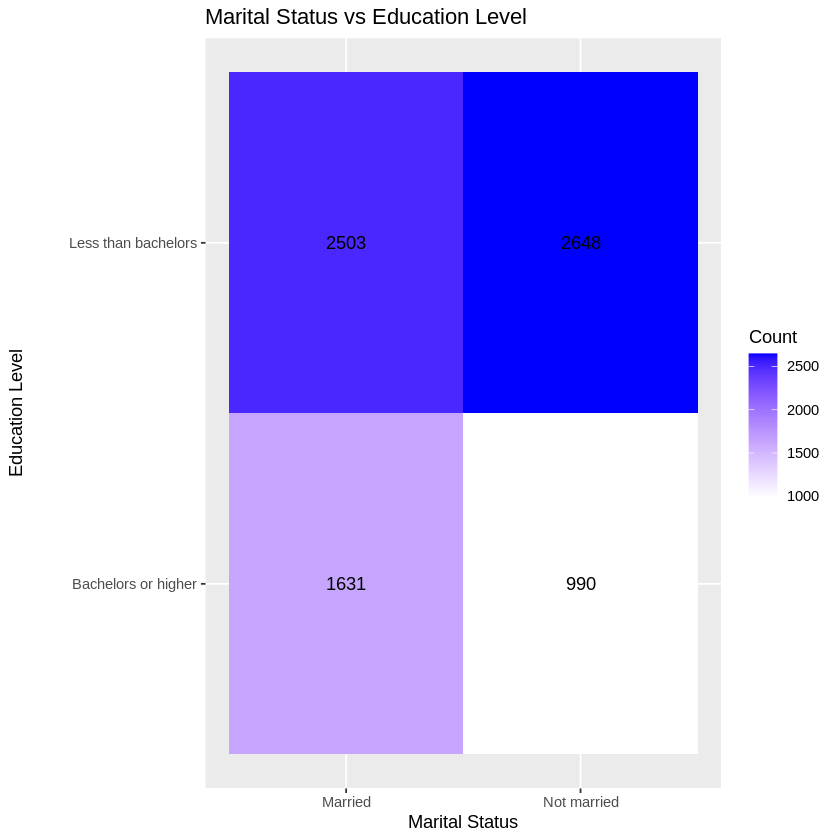

In [129]:
table_melt <- as.data.frame(table_chi)
ggplot(table_melt, aes(x = Var2, y = Var1, fill = Freq)) +
  geom_tile() +
  geom_text(aes(label = Freq), color = "black") +
  scale_fill_gradient(low = "white", high = "blue") +
  labs(title = "Marital Status vs Education Level",
       x = "Marital Status",
       y = "Education Level",
       fill = "Count")

##### The p-value is less than 0.05, indicating a statistically significant association between marital status and education level. Married individuals are more likely to have a bachelor’s degree or higher, while those who are not married are more likely to have less than a bachelor’s degree.

# Question 2: "Is there a difference in the mean sedentary behavior time between those who are married and those who are not married?"



	Welch Two Sample t-test

data:  PAD680 by DMDMARTZ
t = -3.8514, df = 7398.8, p-value = 0.0001184
alternative hypothesis: true difference in means between group Married and group Not married is not equal to 0
95 percent confidence interval:
 -28.173263  -9.167526
sample estimates:
    mean in group Married mean in group Not married 
                 353.2871                  371.9575 

    Married Not married 
   353.2871    371.9575 


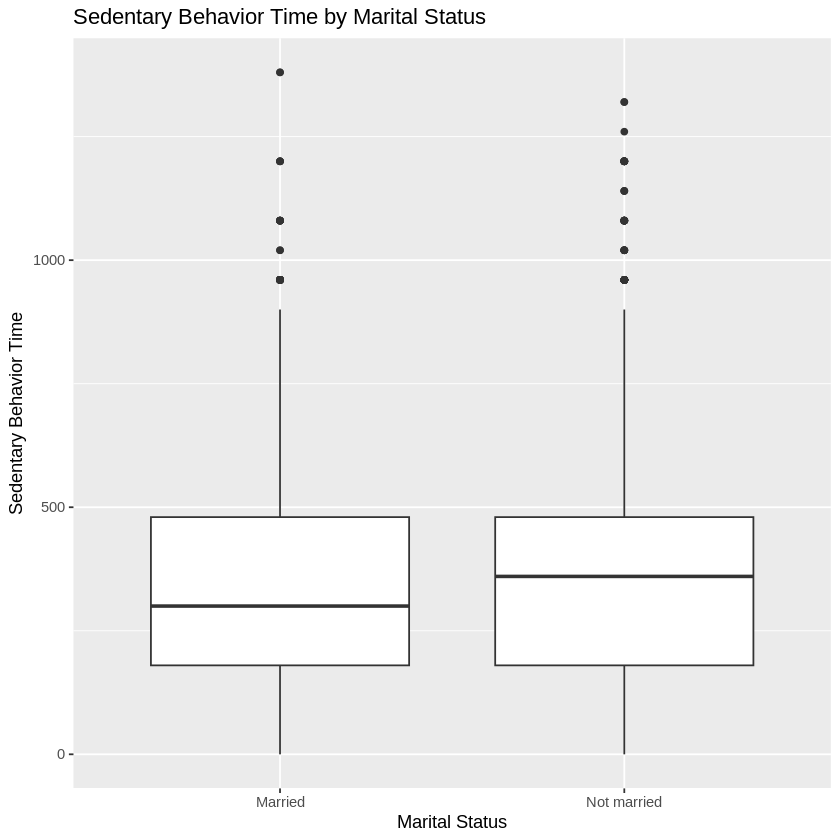

In [130]:
q2 <- df %>% select(DMDMARTZ, PAD680) %>% drop_na()

t_res <- t.test(PAD680 ~ DMDMARTZ, data = q2)
print(t_res)

# Calculate group means
print(with(q2, tapply(PAD680, DMDMARTZ, mean, na.rm = TRUE)))

# Boxplot for visualization
ggplot(q2, aes(x = DMDMARTZ, y = PAD680)) +
  geom_boxplot() +
  labs(title = "Sedentary Behavior Time by Marital Status",
       x = "Marital Status",
       y = "Sedentary Behavior Time")

 A p-value less than 0.05 indicates a statistically significant difference. Individuals who are married have lower sedentary behavior time compared to those who are not married.

# Question 3: Question 3: "How do age and marital status affect systolic blood pressure?"



In [131]:
q3 <- df %>% select(BPXOSY3, RIDAGEYR, DMDMARTZ) %>% drop_na()
lm_model <- lm(BPXOSY3 ~ RIDAGEYR + DMDMARTZ, data = q3)
print(summary(lm_model))


Call:
lm(formula = BPXOSY3 ~ RIDAGEYR + DMDMARTZ, data = q3)

Residuals:
    Min      1Q  Median      3Q     Max 
-63.251 -11.145  -1.461   9.380 106.126 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)         100.81805    0.78468 128.483  < 2e-16 ***
RIDAGEYR              0.39524    0.01313  30.105  < 2e-16 ***
DMDMARTZNot married   1.34197    0.45086   2.976  0.00293 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 17.1 on 5835 degrees of freedom
Multiple R-squared:  0.1345,	Adjusted R-squared:  0.1342 
F-statistic: 453.3 on 2 and 5835 DF,  p-value: < 2.2e-16



`geom_smooth()` using formula = 'y ~ x'


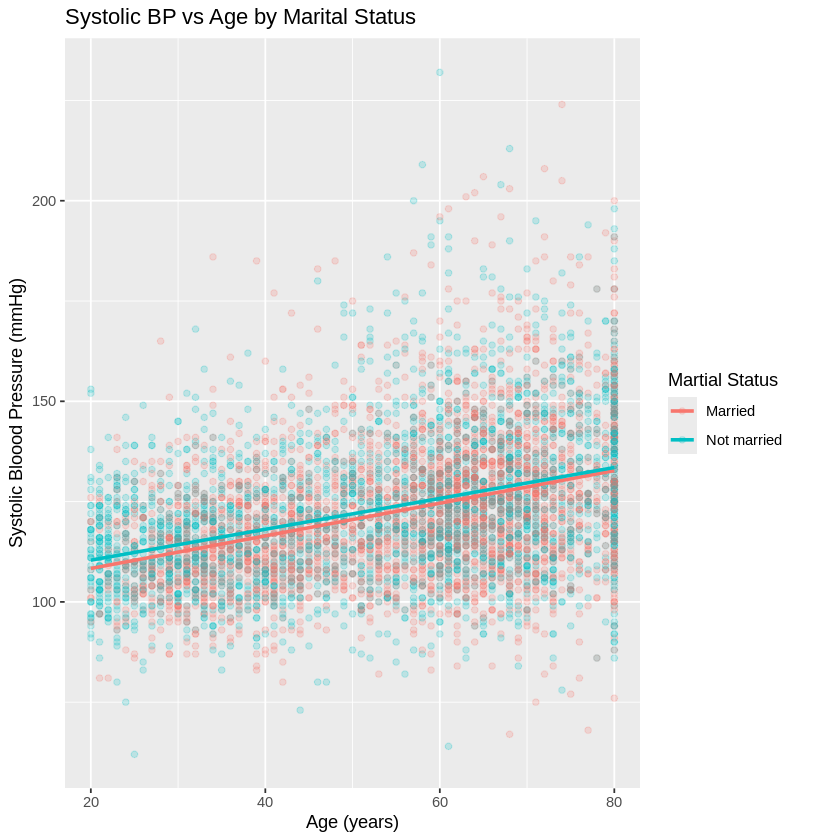

In [132]:
ggplot(q3, aes(x = RIDAGEYR, y = BPXOSY3, color = DMDMARTZ)) +
  geom_point(alpha = 0.2) +
  geom_smooth(method = "lm", se = FALSE) +
  labs(title = "Systolic BP vs Age by Marital Status",
    x = "Age (years)",
    y = "Systolic Bloood Pressure (mmHg)",
    color = "Martial Status")

As the population ages, systolic blood pressure increases. Being married or not married does not appear to play a major role in systolic blood pressure. There may be a slight increase in systolic pressure among individuals who are not married compared to those who are married.

# Question 4: Is there a correlation between self-reported weight and minutes of sedentary behavior?

In [133]:
q4 <- df %>% select(WHD020, PAD680) %>% drop_na()
cor_res <- cor.test(q4$WHD020, q4$PAD680, method = "pearson")
print(cor_res)


	Pearson's product-moment correlation

data:  q4$WHD020 and q4$PAD680
t = 14.081, df = 7952, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.1344554 0.1773405
sample estimates:
      cor 
0.1559715 



`geom_smooth()` using formula = 'y ~ x'


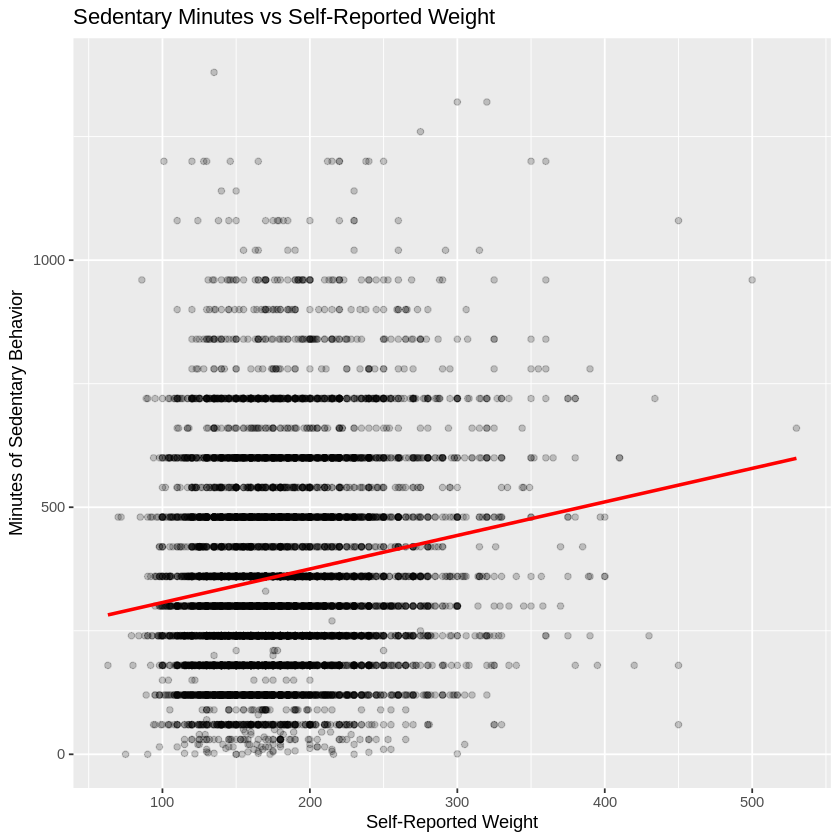

In [134]:
ggplot(q4,aes(x =WHD020, y = PAD680)) +
  geom_point(alpha = 0.2) +
  geom_smooth(method = 'lm', se = FALSE, color = "red") +
  labs(title = "Sedentary Minutes vs Self-Reported Weight",
    x = "Self-Reported Weight",
    y = "Minutes of Sedentary Behavior")

A Pearson correlation was conducted to examine the relationship between self-reported weight and sedentary behavior. Results show a weak positive correlation between the two columns. The correlation strength (r = 0.15597) indicates a weak positive relationship. The p-value shows that the correlation is unlikely to be due to random chance.

# Question 5: (Creative Analysis): Is there a difference in mean sedentary behavior time across vitamin D interpretation levels and weak/failing kidney status?


In [135]:
df <- df %>%
  mutate(LBDVD2LC = round(as.numeric(LBDVD2LC), 0),
         LBDVD2LC = case_when(
           LBDVD2LC == 0 ~ "Normal",
           LBDVD2LC == 1 ~ "Low",
           TRUE ~ NA_character_
         ))

q5 <- df %>%
  select(PAD680, LBDVD2LC, KIQ022) %>% # Select relevant columns before dropping NAs
  drop_na()

In [136]:
# Calculate mean sedentary behavior time for each group
mean_sedentary_time <- q5 %>%
  group_by(LBDVD2LC, KIQ022) %>%
  summarise(mean_PAD680 = mean(PAD680, na.rm = TRUE))

print(mean_sedentary_time)

`summarise()` has grouped output by 'LBDVD2LC'. You can override using the
`.groups` argument.


# A tibble: 4 × 3
# Groups:   LBDVD2LC [2]
  LBDVD2LC KIQ022          mean_PAD680
  <chr>    <chr>                 <dbl>
1 Low      Never been told        361.
2 Low      Weak/Failing           375.
3 Normal   Never been told        372.
4 Normal   Weak/Failing           407.


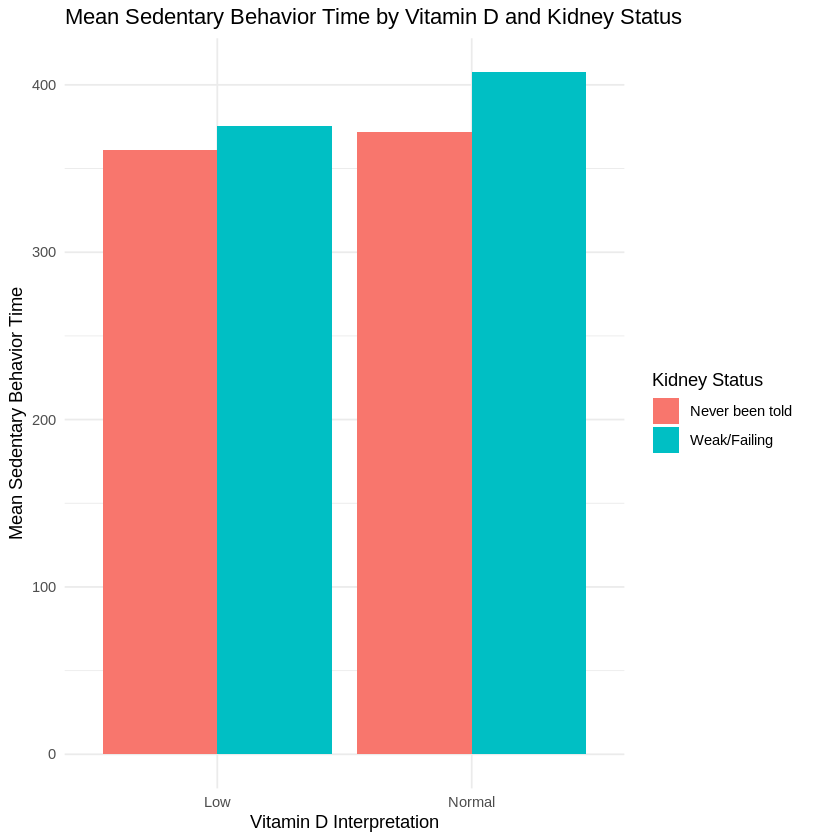

In [137]:
# Visualize the mean sedentary behavior time
ggplot(mean_sedentary_time, aes(x = LBDVD2LC, y = mean_PAD680, fill = KIQ022)) +
  geom_bar(stat = "identity", position = position_dodge()) +
  labs(title = "Mean Sedentary Behavior Time by Vitamin D and Kidney Status",
       x = "Vitamin D Interpretation",
       y = "Mean Sedentary Behavior Time",
       fill = "Kidney Status") +
  theme_minimal()

The bar plot shows that mean sedentary minutes are similar across both vitamin D interpretation levels and kidney status groups, with only small differences between the bars.
##### The p-values (PR(>F)) were all above 0.05, indicating that the results were not significant.
##### The visual pattern shows no significant main effects or interaction between vitamin D status and weak/failing kidneys on sedentary behavior.
##### The chart shows that people with weak/failing kidneys had slightly more sedentary minutes than those who have never been told. People with low vitamin D also had slightly fewer mean sedentary minutes compared to those with normal vitamin D results. Although it appears this way visually, the differences are minimal.